In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
file_path = '../data/data-reduced-train.csv'
data = pd.read_csv(file_path)

### Get basic info on median house income feature
Here is a heat map with Income data by counties https://www.census.gov/library/visualizations/interactive/median-household-income.html

In [3]:
data['Median Household Income'].describe()

count      2513.000000
mean      63367.031437
std       16377.967261
min       28972.000000
25%       52483.000000
50%       60907.000000
75%       70594.000000
max      167605.000000
Name: Median Household Income, dtype: float64

### Split the DataFrame into two based on the median (set this up so it can be done for any feature)

In [4]:
feature = 'Median Household Income'
#feature = '% Non-Hispanic White'
median_feature = data[feature].median()
feature_bottom_50 = data[data[feature] <= median_feature]
feature_top_50 = data[data[feature] > median_feature]

In [5]:
%run ../data/features-grouped.ipynb #This has a "feature_list" and "features_by_category"
%run ../data/model-information.ipynb 

In [6]:
# health_behaviors_features = features_by_category["Health Behaviors"]
# access_to_care_features = features_by_category['Access to Care']
# socio_economic_features = features_by_category['Socio-economic Factors']
# physical_environment_features = features_by_category['Physical Environment']
# demographics_features = features_by_category['Demographics']

In [37]:
features = data.columns[4:].to_list()
#features.remove('Median Household Income')
target = data.columns[3] #'% Adults with Diabetes'

# Run XGB with optimized hyperparameters 

### Below median counties

In [39]:
df = feature_bottom_50.copy()
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

def model_rmse(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

params = xgb_best_params_full
n_neighbors = 10 #neighbors for kNN imputation
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

xgb_pipe.fit(df_train[features], df_train[target])

train_rmse = float(model_rmse(xgb_pipe, df_train, features, target))
val_rmse = float(model_rmse(xgb_pipe, df_val, features, target))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

Training RMSE: 0.2321
Validation RMSE: 0.4827


In [40]:
category_colors = {
    "Health Behaviors": "blue",
    "Access to Care": "green",
    "Socio-economic Factors": "orange",
    "Physical Environment": "purple",
    "Demographics": "brown",
}

feature_to_category = {}
for category, feature_list in features_by_category.items():
    for feature in feature_list:
        feature_to_category[feature] = category

In [55]:
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

def get_sorted_model_importance_frame(model, df, features, target):
   model.fit(df[features], df[target])

   importances = model['xgb'].feature_importances_
   return pd.DataFrame({'Feature': features,
                               'importance_score': importances})\
                                .sort_values(by='importance_score', ascending=False)


def plot_top_model_importances(importance_frame, top_n=15, title=''):
   importance_frame['Category'] = importance_frame['Feature'].map(feature_to_category)
   importance_frame['Color'] = importance_frame['Category'].map(category_colors)

   #This function assumes the frame is already sorted by importance score, in descending order
   top_importances = importance_frame.head(top_n)

   plt.figure(figsize=(12,8))
   ax = sns.barplot(data=top_importances, y='Feature', x='importance_score', orient='h', hue='Category', palette=category_colors)
   plt.xlabel('Importance')
   plt.ylabel('')
   ax.tick_params(axis='y', labelsize=14)
   plt.xlim(0, 0.35) 
   plt.title(title)
   legend_elements = [Patch(facecolor=color, edgecolor='gray', label=category) for category, color in category_colors.items()]
   plt.legend(handles=legend_elements, title='Feature Categories', loc='lower right',fontsize = 14)
   plt.tight_layout()
   plt.show()

In [53]:
# Re-trains model on the entire training subset of super-median counties
bottom_50_importances = get_sorted_model_importance_frame(model = xgb_pipe, 
                                                                 df = feature_bottom_50, 
                                                                 features=features, 
                                                                 target=target)

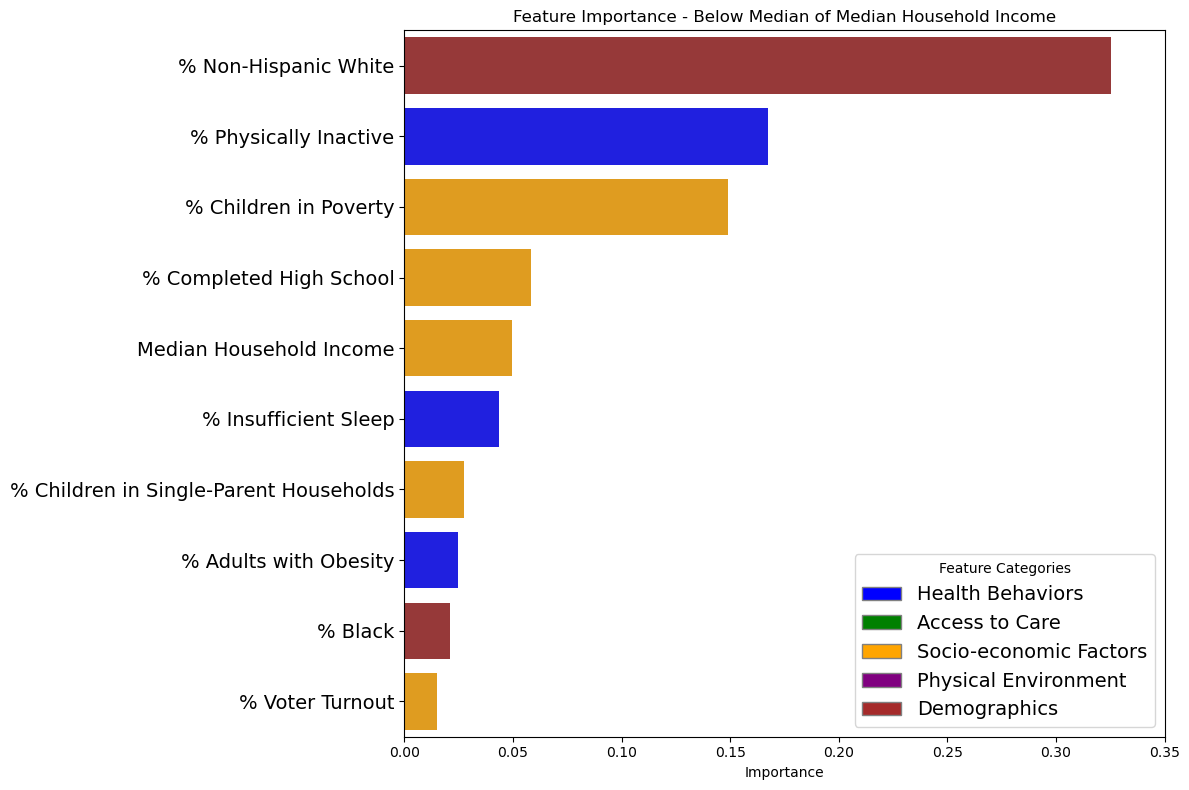

In [56]:
plot_top_model_importances(bottom_50_importances, top_n=10, title='Feature Importance - Below Median of Median Household Income')

### Above median counties

In [44]:
df = feature_top_50.copy()
df_train, df_val = train_test_split(df, test_size=0.1, random_state=42)

def model_rmse(model, df, features, target):
    model_preds = model.predict(df[features])
    return root_mean_squared_error(df[target], model_preds)

params = xgb_best_params_full
n_neighbors = 10 #neighbors for kNN imputation
xgb_pipe = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

xgb_pipe.fit(df_train[features], df_train[target])

train_rmse = float(model_rmse(xgb_pipe, df_train, features, target))
val_rmse = float(model_rmse(xgb_pipe, df_val, features, target))

print(f'Training RMSE: {train_rmse:.4f}')
print(f'Validation RMSE: {val_rmse:.4f}')

Training RMSE: 0.2005
Validation RMSE: 0.4587


In [45]:
model = Pipeline([('impute', KNNImputer(n_neighbors=n_neighbors)),
                     ('xgb', XGBRegressor(**params))])

#Trains the model on all the submedian counties in the training set
top_50_importances = get_sorted_model_importance_frame(model, feature_top_50, features, target)

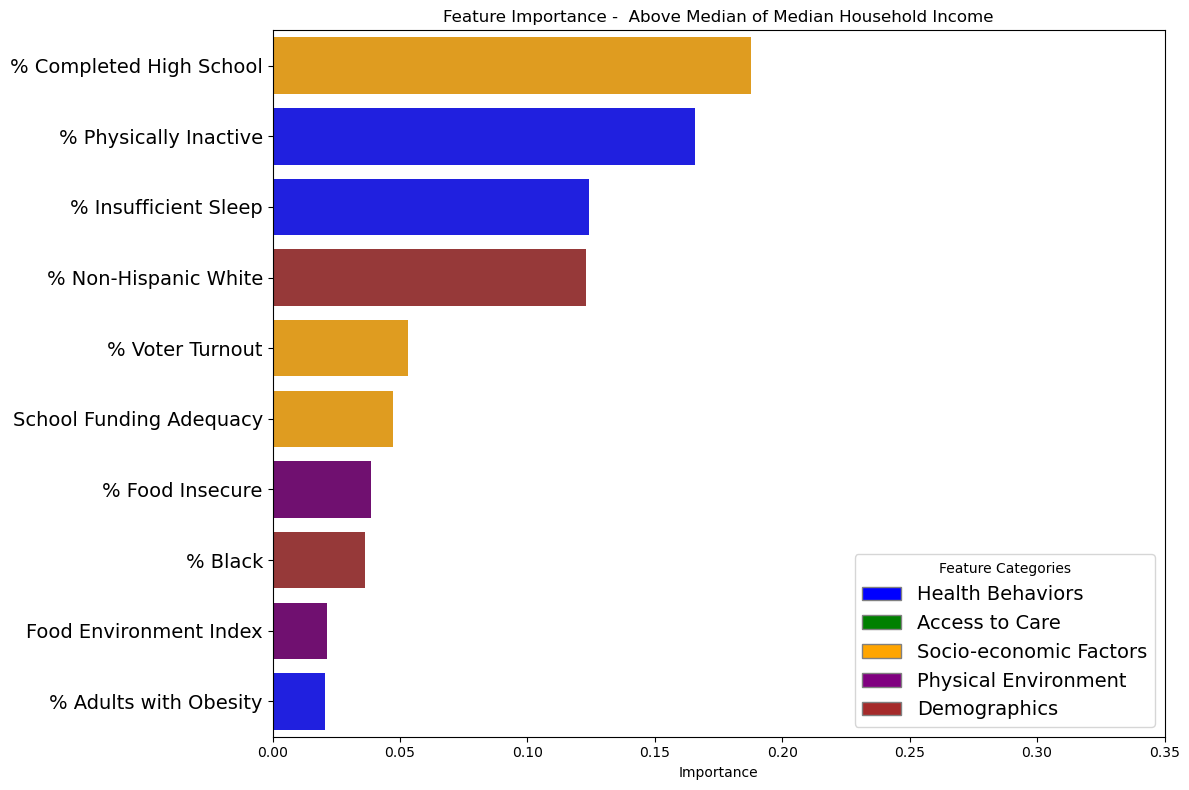

In [57]:
plot_top_model_importances(top_50_importances, 
                           top_n=10, 
                           title = 'Feature Importance -  Above Median of Median Household Income')